# Elastic deformation (Dead Sea shape)

## Tools

*Modules*

In [1]:
import numpy as np
from scipy.special import ellipe, ellipk
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
import json
import scipy.stats as ss
from astropy.time import Time

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.cm as cmx
import matplotlib.ticker as ti
from matplotlib import patheffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmcrameri.cm as cmc

import cartopy.crs as ccrs
import cartopy.feature as cf
import pygmt
from pygmt.datasets import load_earth_relief
from fontTools.ttLib import TTFont
from matplotlib.font_manager import fontManager, FontProperties
from adjustText import adjust_text

In [2]:
plt.style.use('myfig.mplstyle')

*Functions*

In [3]:
def found_font_with_unicode_char(list_unichars):
    
    def char_in_font(unicode_char, font):
        if font.endswith('.ttc'):
            fontNo = 0
        else:
            fontNo = -1
        font = TTFont(font, fontNumber=fontNo)
        for cmap in font['cmap'].tables: 
            if cmap.isUnicode():
                for i in unicode_char:
                    if ord(i) not in cmap.cmap:
                        return False
        return True

    font_list = [(f.fname, f.name) for f in fontManager.ttflist]
    for font in font_list:
        if char_in_font(list_unichars, font[0]):
            return FontProperties(fname=font[0])
    
    return None


def draw_scalebar(ax, length, location=(.9, .9), linewidth=3, units='km', m_per_unit=1000):    
    """
    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    
    def utm_from_lon(lon):
        """
        utm_from_lon - UTM zone for a longitude
        Not right for some polar regions (Norway, Svalbard, Antartica)
        :param float lon: longitude
        :return: UTM zone number
        :rtype: int
        """
        return int(np.floor((lon+180)/6)+1)
    
    proj = ax.projection
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
            linewidth=linewidth, path_effects=buffer)
    # Plot the scalebar label
    ax.text(sbcx, sbcy+(y1 - y0)*0.01, '{:} {:}'.format(length, units), transform=utm,
            ha='center', va='bottom', path_effects=buffer, zorder=2)
    return


def draw_north_arrow(ax, location=(.1, .9)):    
    """
    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    
    def utm_from_lon(lon):
        """
        utm_from_lon - UTM zone for a longitude
        Not right for some polar regions (Norway, Svalbard, Antartica)
        :param float lon: longitude
        :return: UTM zone number
        :rtype: int
        """
        return int(np.floor((lon+180)/6)+1)
    
    proj = ax.projection
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the arow location into coordinates in metres
    sbcx = x0 + (x1 - x0) * location[0]
    sbcy = y0 + (y1 - y0) * location[1]
    # buffer and plot
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    ax.text(sbcx, sbcy, u'\u25B2\nN', fontproperties=found_font_with_unicode_char([u"\u25B2"]),
            transform=utm, ha='center', va='bottom', path_effects=buffer)
    return

*Paths*

In [4]:
# paths
wkdir = "/Users/emile/Documents/Etude/2024_2025_M2/tutored_project"
datadir = "{:}/data".format(wkdir)
plotdir = "{:}/figures".format(wkdir)

*Dead Sea shapefile*

In [5]:
crs_geo = 'EPSG:4326'
crs_utm = 'EPSG:32636'

In [6]:
dead_sea_shp_geo = gpd.read_file("{:}/Dead_sea_shapefile/dead_sea.shp".format(datadir))
dead_sea_shp_utm = dead_sea_shp_geo.to_crs(crs_utm)

In [7]:
x_dead_sea, y_dead_sea = dead_sea_shp_utm.geometry[0].exterior.xy
x_dead_sea = np.array(x_dead_sea)
y_dead_sea = np.array(y_dead_sea)

*Import mesh*

In [8]:
res = 8

mesh_disk_geo = pd.read_csv("{:}/Dead_Sea_mesh/mesh_geo_res{:}.txt".format(datadir, res), sep='\t')
mesh_disk_utm = pd.read_csv("{:}/Dead_Sea_mesh/mesh_utm_res{:}.txt".format(datadir, res), sep='\t')

Ndisk = len(mesh_disk_geo)

*Import GNSS data*

In [9]:
list_sta = pd.read_csv("{:}/GNSS/list_stations_dead_sea.txt".format(datadir),
                       sep = '\t')
list_sta = list_sta[list_sta.code.isin(['ALON', 'BALJ', 'CSAR', 'DRAG', 'DSEA', 'GHAJ', 'GILB', 'JSLM', 'KHLV', 'LHAV', 'MAS5', 'NRIF', 'TELA', 'TMAR', 'UJAP', 'YOSH', 'YRCM', 'RAMO'])]
list_sta.reset_index(inplace=True)

In [10]:
start_date = '2005-01-01'
end_date = '2025-01-01'

In [11]:
STA_REF = 'RAMO'

In [12]:
gnss_ref = {}
        
gnss_ref['data'] = pd.read_csv("{:}/GNSS/{:}.tenv3".format(datadir, STA_REF),
                                sep=' ', skipinitialspace=True)

gnss_ref['data']['datetime'] = pd.to_datetime(gnss_ref['data']['YYMMMDD'], format='%y%b%d')

gnss_ref['data'].set_index("datetime", inplace=True)
gnss_ref['data'].sort_index(inplace=True)

gnss_ref['data'] = gnss_ref['data'].reindex(pd.date_range(start=start_date, end=end_date, freq='D'))
gnss_ref['data'] = gnss_ref['data'].interpolate(method='linear')

zscore = (np.abs(ss.zscore(gnss_ref['data'][['__east(m)', '_north(m)', '____up(m)']], nan_policy='omit')) >= 3).any(axis=1)
gnss_ref['data'].loc[zscore, ['__east(m)', '_north(m)', '____up(m)', 'sig_e(m)', 'sig_n(m)', 'sig_u(m)']] = np.nan

gnss_ref['lon'] = list_sta[list_sta.code == STA_REF].lon.values[0]
gnss_ref['lat'] = list_sta[list_sta.code == STA_REF].lat.values[0]
gnss_ref['x'] = list_sta[list_sta.code == STA_REF].x.values[0]
gnss_ref['y'] = list_sta[list_sta.code == STA_REF].y.values[0]
gnss_ref['z'] = list_sta[list_sta.code == STA_REF].height.values[0]

/var/folders/58/4tzv12sd173350mg97rbrhwc0000gn/T/ipykernel_9898/3213552933.py:12: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  gnss_ref['data'] = gnss_ref['data'].interpolate(method='linear')


In [13]:
gnss_data = {}

for idx, row in list_sta.iterrows():
    
    if row.code != STA_REF:
        
        try:
    
            gnss_data[row.code] = {}
            
            gnss_data[row.code]['data'] = pd.read_csv("{:}/GNSS/{:}.tenv3".format(datadir, row.code),
                                            sep=' ', skipinitialspace=True)
            
            gnss_data[row.code]['data']['datetime'] = pd.to_datetime(gnss_data[row.code]['data']['YYMMMDD'], format='%y%b%d')
            
            gnss_data[row.code]['data'].set_index("datetime", inplace=True)
            gnss_data[row.code]['data'].sort_index(inplace=True) 

            gnss_data[row.code]['data'] = gnss_data[row.code]['data'].reindex(pd.date_range(start=start_date, end=end_date, freq='D'))
            
            zscore = (np.abs(ss.zscore(gnss_data[row.code]['data'][['__east(m)', '_north(m)', '____up(m)']], nan_policy='omit')) >= 3).any(axis=1)
            gnss_data[row.code]['data'].loc[zscore, ['__east(m)', '_north(m)', '____up(m)', 'sig_e(m)', 'sig_n(m)', 'sig_u(m)']] = np.nan
            
            tref = gnss_data[row.code]['data'].first_valid_index()

            gnss_data[row.code]['data'][['__east(m)', '_north(m)', '____up(m)']] -= gnss_data[row.code]['data'].loc[tref, ['__east(m)', '_north(m)', '____up(m)']]
            gnss_data[row.code]['data'][['__east(m)', '_north(m)', '____up(m)']] += gnss_ref['data'].loc[tref, ['__east(m)', '_north(m)', '____up(m)']]
            gnss_data[row.code]['data'][['__east(m)', '_north(m)', '____up(m)']] -= gnss_ref['data'][['__east(m)', '_north(m)', '____up(m)']]
            
            gnss_data[row.code]['data'][['sig_e(m)', 'sig_n(m)', 'sig_u(m)']] = np.sqrt((gnss_data[row.code]['data'][['sig_e(m)', 'sig_n(m)', 'sig_u(m)']])**2 + (gnss_ref['data'][['sig_e(m)', 'sig_n(m)', 'sig_u(m)']])**2) 
            
            gnss_data[row.code]['lon'] = row.lon
            gnss_data[row.code]['lat'] = row.lat
            gnss_data[row.code]['x'] = row.x
            gnss_data[row.code]['y'] = row.y
            gnss_data[row.code]['z'] = row.height
            
        except:
            
            gnss_data.pop(row.code)

*Dead Sea water level*

In [14]:
# Dead sea level (1976 - 2024)

with open("{:}/Dead_Sea_level/Dead_Sea_level_1976_2024.json".format(datadir)) as f:
    dead_sea_level = json.load(f)

dead_sea_level = pd.DataFrame(dead_sea_level['result']['records'])
dead_sea_level["date"] = pd.to_datetime(dead_sea_level["תאריך מדידה"], format="%d/%m/%Y")
dead_sea_level["sea_level"] = dead_sea_level["מפלס"].astype('float64')
dead_sea_level = dead_sea_level.drop(labels=['_id', 'תאריך מדידה', 'מפלס'], axis=1)
dead_sea_level.sort_values('date', inplace=True)
dead_sea_level.reset_index(drop=True, inplace=True)
dead_sea_level['decimal_year'] = np.array([Time(t, format='datetime').decimalyear for t in dead_sea_level["date"]])
dead_sea_level.set_index('date', inplace=True)
dead_sea_level = dead_sea_level.truncate(before=start_date, after=end_date)

*Functions*

In [15]:
def elastic_vertical_displacement(r, p, a, nu, E):
    """
    This function computes the vertical displacement of the
    surface generated by a uniform load over a circular area
    at a given distance.
    
    From:
    
    Verruijt, A. (2010). Elastodynamics of a Half Space.
    In: An Introduction to Soil Dynamics. Theory and Applications
    of Transport in Porous Media, vol 24. Springer,
    Dordrecht. https://doi.org/10.1007/978-90-481-3441-0_9
    
    Johnson, K. L. (1987). Contact mechanics. Cambridge University Press.

    Args:
        r (array of floats): distance at which the surface displacement is computed (m)
        p (float): load over the circular area (Pa)
        a (float): radius of the circular loaded area (m)
        nu (float): Poisson's ratio of the encasing rock
        E (float): Young's modulus of the encasing rock (Pa)
    """
    
    u = np.zeros_like(r)
    
    x = r**2/a**2
    u[r <= a] = - 4*p*a*(1-nu**2)/(np.pi*E)*ellipe(x[r <= a])
    u[r > a] = - 4*p*r[r > a]*(1-nu**2)/(np.pi*E)*(ellipe(1/x[r > a])-(1-1/x[r > a])*ellipk(1/x[r > a]))
    
    return u


def elastic_radial_displacement(r, p, a, nu, E):
    """
    This function computes the radial displacement of the
    surface generated by a uniform load over a circular area
    at a given distance.
    
    From:
    
    Verruijt, A. (2010). Elastodynamics of a Half Space.
    In: An Introduction to Soil Dynamics. Theory and Applications
    of Transport in Porous Media, vol 24. Springer,
    Dordrecht. https://doi.org/10.1007/978-90-481-3441-0_9
    
    Johnson, K. L. (1987). Contact mechanics. Cambridge University Press.

    Args:
        r (array of floats): distance at which the surface displacement is computed (m)
        p (float): load over the circular area (Pa)
        a (float): radius of the circular loaded area (m)
        nu (float): Poisson's ratio of the encasing rock
        E (float): Young's modulus of the encasing rock (Pa)
    """
    
    u = np.zeros_like(r)
    
    x = r**2/a**2
    u[r <= a] = - (1-2*nu)*(1+nu)/(2*E)*p*r[r <= a]
    u[r > a] = - (1-2*nu)*(1+nu)/(2*E)*p*a**2/r[r > a]
    
    return u

## Surface displacements

*Physical parameters*

In [16]:
# Poisson's ratio (encasing rock of the Dead Sea)
nu = .3

# Young's modulus (encasing rock of the Dead Sea)
E = 100e9 # Pa

# Gravity acceleration
g = 9.81 # m.s-2

*Load*

In [17]:
# The Dead sea has a surface of ~605 km2 (2016)
disk_radius = mesh_disk_utm.radius.values[0] # m

# Density
rho_sea = 1240 # kg.m-3

*Computations*

In [18]:
# Reference station

sta_x = gnss_ref['x']
sta_y = gnss_ref['y']

sta_Ux = np.zeros(len(dead_sea_level))
sta_Uy = np.zeros(len(dead_sea_level))
sta_Uz = np.zeros(len(dead_sea_level))

# displacements

for it in range(1, len(dead_sea_level)):
    
    dh = dead_sea_level.sea_level[it] - dead_sea_level.sea_level[0]
    p = rho_sea * g * dh

    for id in range(len(mesh_disk_utm)):
        
        R_sta = np.sqrt((sta_x - mesh_disk_utm.x[id])**2+(sta_y - mesh_disk_utm.y[id])**2)
        
        sta_Uz[it] += elastic_vertical_displacement(R_sta, p, disk_radius, nu, E)
        
        Ur = elastic_radial_displacement(R_sta, p, disk_radius, nu, E)
        
        sta_Ux[it] += (sta_x-mesh_disk_utm.x[id])/np.sqrt((sta_x-mesh_disk_utm.x[id])**2+(sta_y-mesh_disk_utm.y[id])**2) * Ur
        sta_Uy[it] += (sta_y-mesh_disk_utm.y[id])/np.sqrt((sta_x-mesh_disk_utm.x[id])**2+(sta_y-mesh_disk_utm.y[id])**2) * Ur

# reference

iref = np.argmin(dead_sea_level.index - gnss_ref['data'].first_valid_index())

sta_Ux -= sta_Ux[iref]
sta_Uy -= sta_Uy[iref]
sta_Uz -= sta_Uz[iref]

gnss_ref['pred'] = pd.DataFrame({"date": dead_sea_level.index,
                                 "decimal_yr": dead_sea_level.decimal_year,
                                 'ux_m': sta_Ux,
                                 'uy_m': sta_Uy,
                                 'uz_m': sta_Uz})
gnss_ref['pred'].set_index('date', inplace=True)

/var/folders/58/4tzv12sd173350mg97rbrhwc0000gn/T/ipykernel_9898/1306058176.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dh = dead_sea_level.sea_level[it] - dead_sea_level.sea_level[0]


In [19]:
for STA in list_sta.code.values:
    
    if STA != STA_REF:

        sta_x = gnss_data[STA]['x']
        sta_y = gnss_data[STA]['y']
        
        sta_Ux = np.zeros(len(dead_sea_level))
        sta_Uy = np.zeros(len(dead_sea_level))
        sta_Uz = np.zeros(len(dead_sea_level))
        
        # displacements

        for it in range(1, len(dead_sea_level)):
            
            dh = dead_sea_level.sea_level[it] - dead_sea_level.sea_level[0]
            p = rho_sea * g * dh

            for id in range(len(mesh_disk_utm)):
                
                R_sta = np.sqrt((sta_x - mesh_disk_utm.x[id])**2+(sta_y - mesh_disk_utm.y[id])**2)
                
                sta_Uz[it] += elastic_vertical_displacement(R_sta, p, disk_radius, nu, E)
                
                Ur = elastic_radial_displacement(R_sta, p, disk_radius, nu, E)
                
                sta_Ux[it] += (sta_x-mesh_disk_utm.x[id])/np.sqrt((sta_x-mesh_disk_utm.x[id])**2+(sta_y-mesh_disk_utm.y[id])**2) * Ur
                sta_Uy[it] += (sta_y-mesh_disk_utm.y[id])/np.sqrt((sta_x-mesh_disk_utm.x[id])**2+(sta_y-mesh_disk_utm.y[id])**2) * Ur
        
        # reference
        
        iref = np.argmin(dead_sea_level.index - gnss_data[STA]['data'].first_valid_index())

        sta_Ux -= sta_Ux[iref]
        sta_Ux += gnss_ref['pred']['ux_m']

        sta_Uy -= sta_Uy[iref]
        sta_Uy += gnss_ref['pred']['uy_m']

        sta_Uz -= sta_Uz[iref]
        sta_Uz += gnss_ref['pred']['uz_m']
        
        gnss_data[STA]['pred'] = pd.DataFrame({"date": dead_sea_level.index,
                                            "decimal_yr": dead_sea_level.decimal_year,
                                                'ux_m': sta_Ux,
                                                'uy_m': sta_Uy,
                                                'uz_m': sta_Uz})
        gnss_data[STA]['pred'].set_index('date', inplace=True)

/var/folders/58/4tzv12sd173350mg97rbrhwc0000gn/T/ipykernel_9898/3467049325.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dh = dead_sea_level.sea_level[it] - dead_sea_level.sea_level[0]


*Plot*

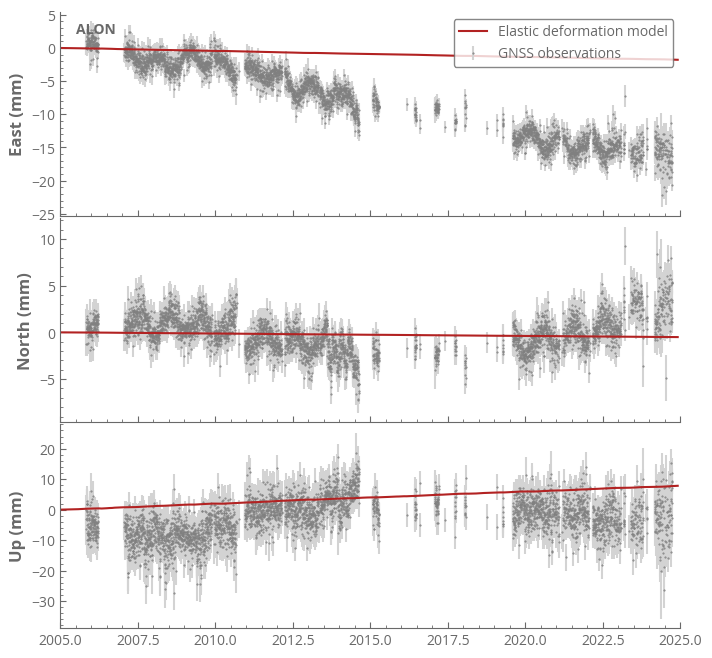

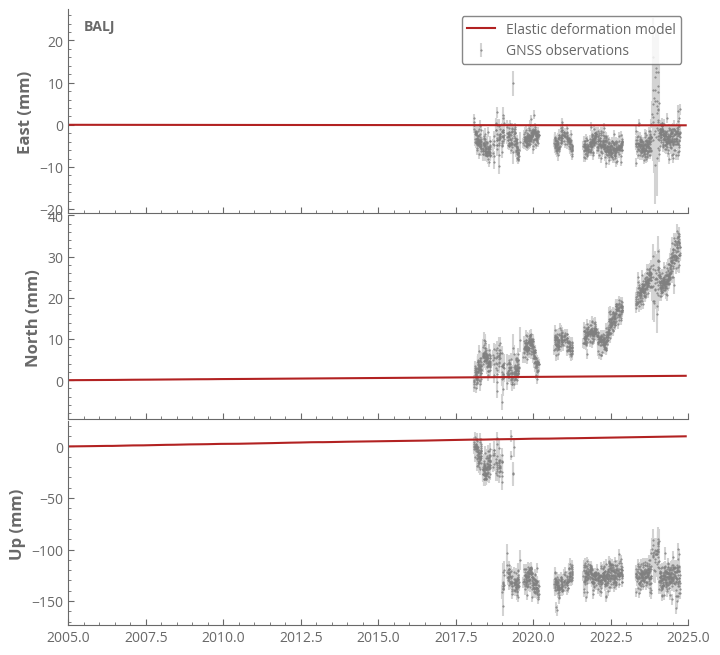

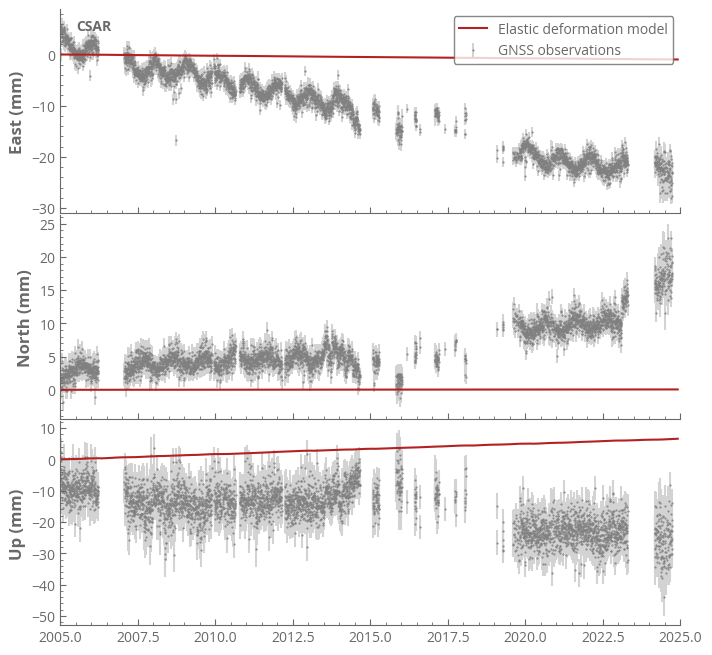

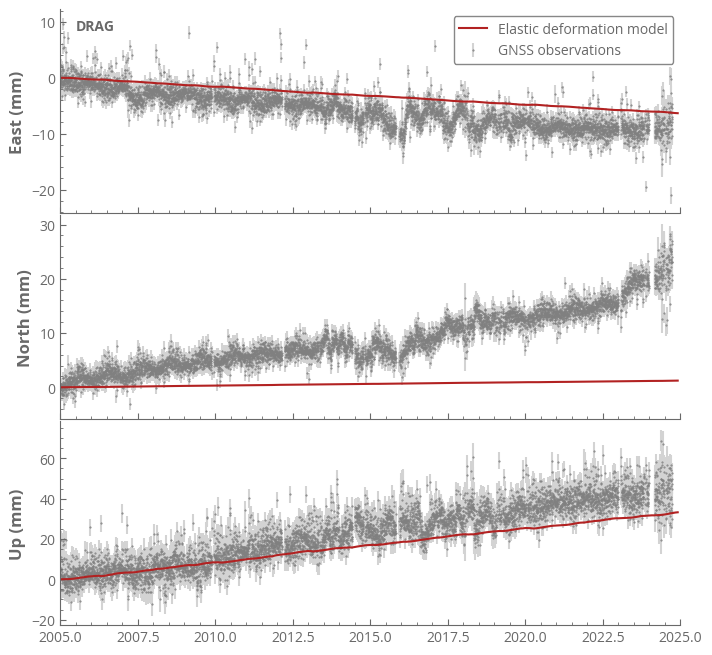

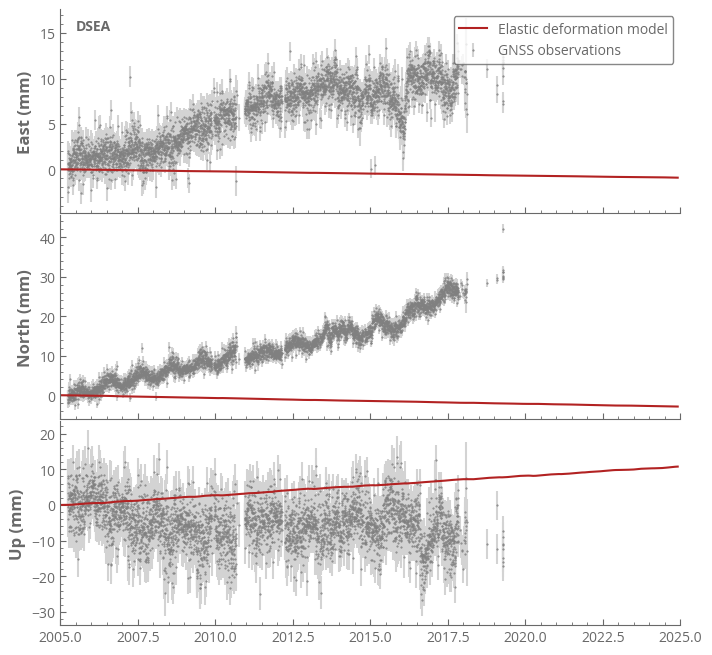

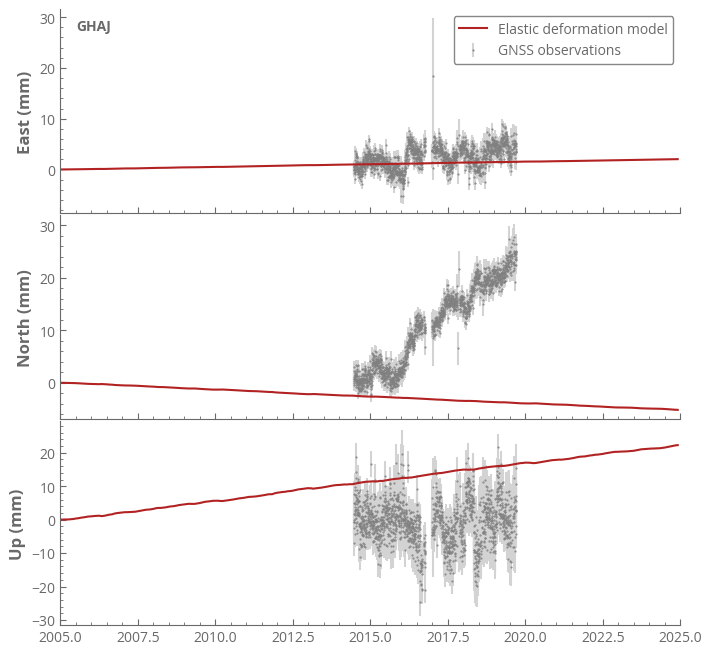

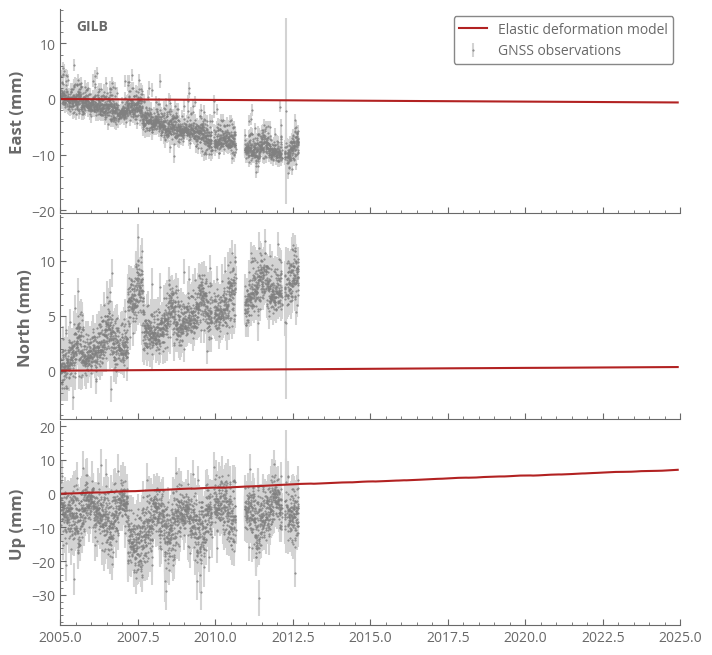

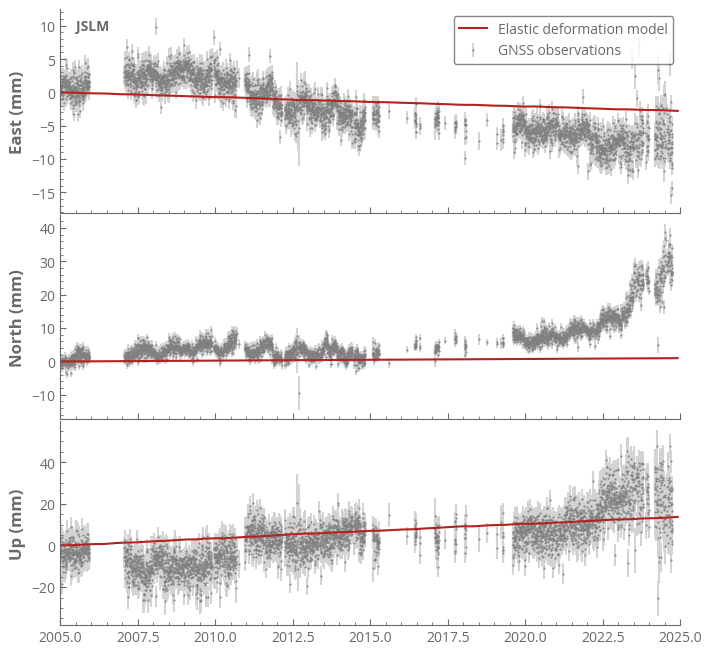

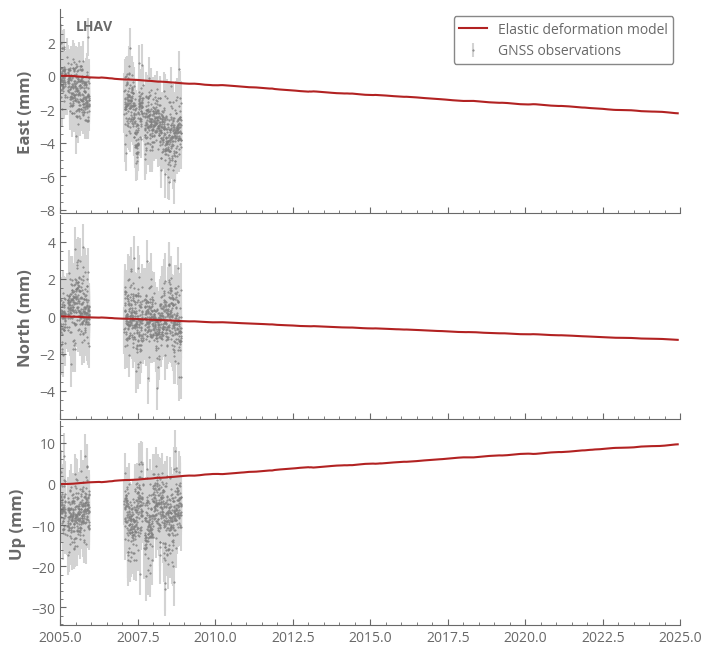

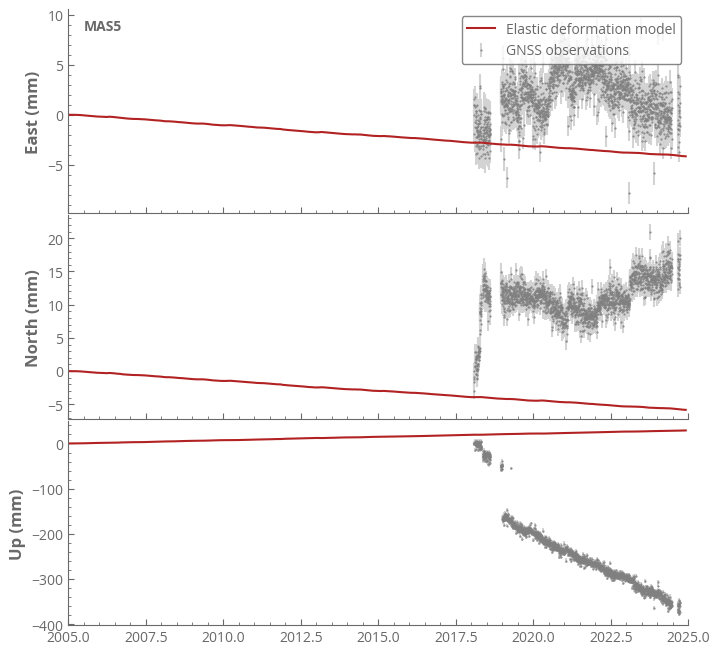

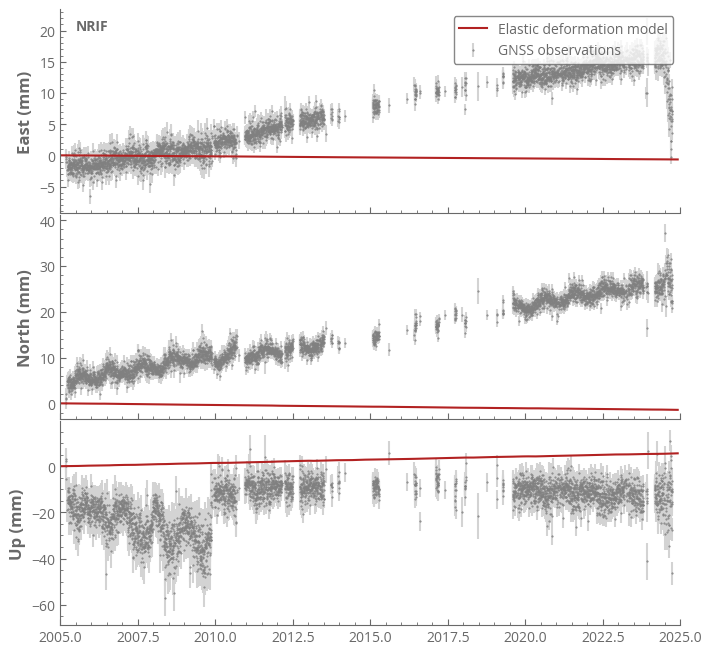

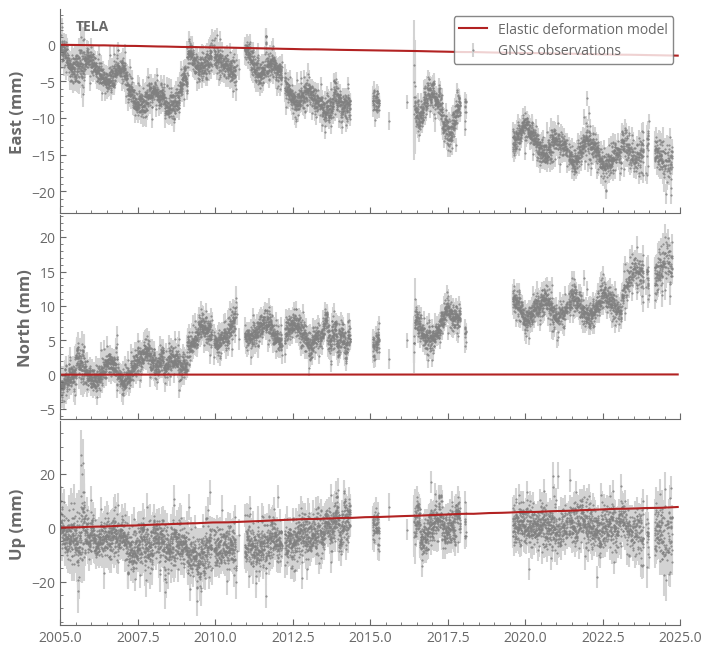

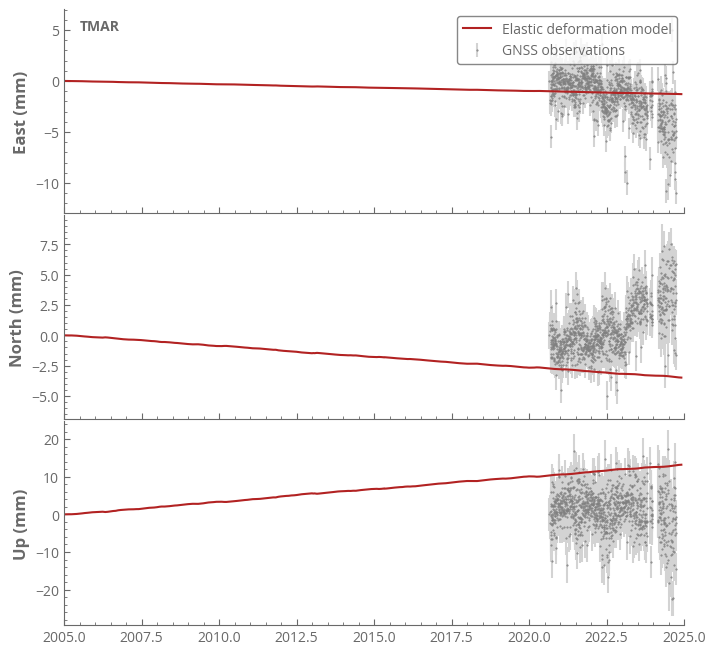

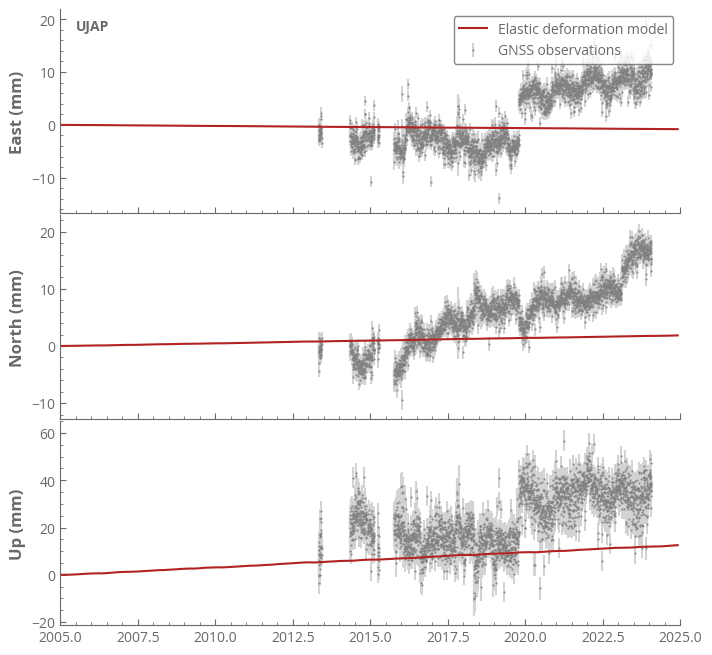

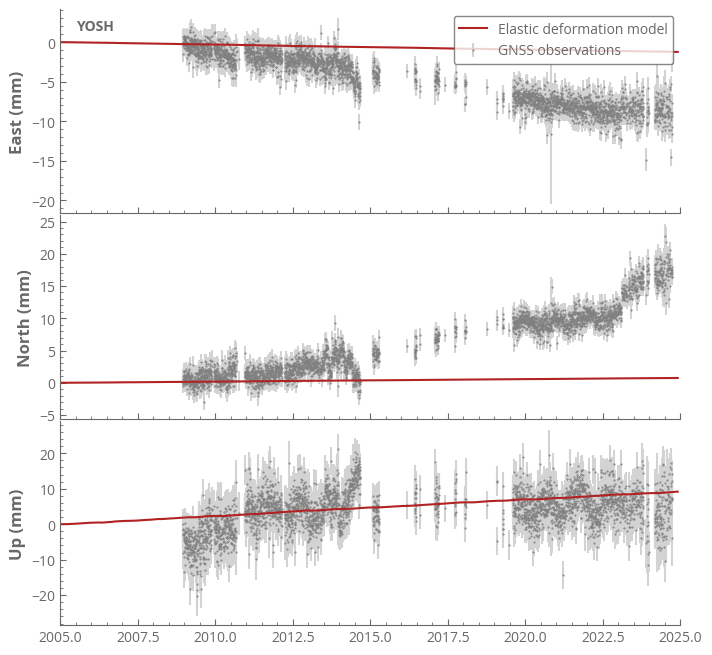

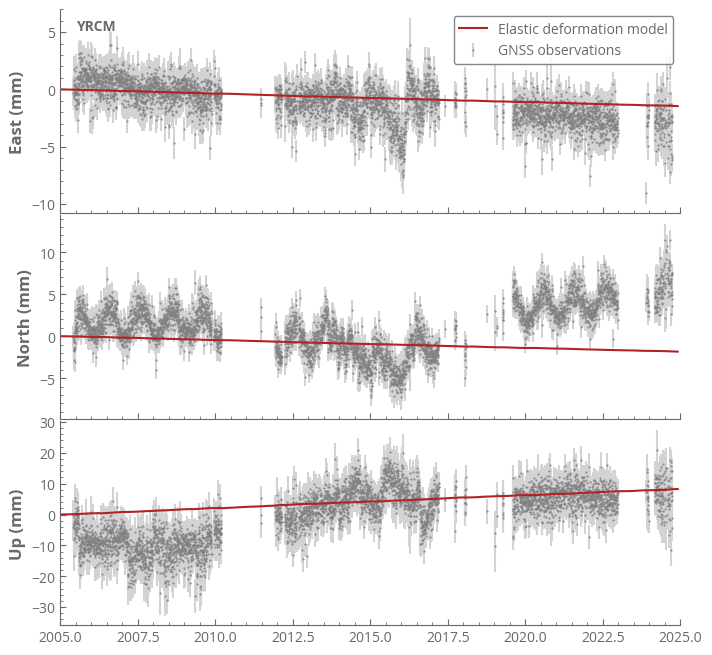

In [20]:
for STA in list_sta.code.values:
    
    if STA != STA_REF:
    
        fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(8, 8))

        ax[0].errorbar(x=gnss_data[STA]['data']['yyyy.yyyy'], y=gnss_data[STA]['data']['__east(m)']*1e3,
                        xerr=None, yerr=gnss_data[STA]['data']['sig_e(m)']*1e3,
                        ecolor='lightgrey', c='grey', marker='.', markersize=1, ls='none', label='GNSS observations', zorder=0)

        ax[1].errorbar(x=gnss_data[STA]['data']['yyyy.yyyy'], y=gnss_data[STA]['data']['_north(m)']*1e3,
                        xerr=None, yerr=gnss_data[STA]['data']['sig_n(m)']*1e3,
                        ecolor='lightgrey', c='grey', marker='.', markersize=1, ls='none', label='Données GNSS', zorder=0)

        ax[2].errorbar(x=gnss_data[STA]['data']['yyyy.yyyy'], y=gnss_data[STA]['data']['____up(m)']*1e3,
                        xerr=None, yerr=gnss_data[STA]['data']['sig_u(m)']*1e3,
                        ecolor='lightgrey', c='grey', marker='.', markersize=1, ls='none', label='Données GNSS', zorder=0)

        ax[0].plot(gnss_data[STA]['pred']['decimal_yr'], gnss_data[STA]['pred']['ux_m']*1e3, c='firebrick', label='Elastic deformation model')
        ax[1].plot(gnss_data[STA]['pred']['decimal_yr'], gnss_data[STA]['pred']['uy_m']*1e3, c='firebrick', )
        ax[2].plot(gnss_data[STA]['pred']['decimal_yr'], gnss_data[STA]['pred']['uz_m']*1e3, c='firebrick', )

        ax[0].set_ylabel('East (mm)')
        ax[1].set_ylabel('North (mm)')
        ax[2].set_ylabel('Up (mm)')
        ax[0].legend(loc='upper right')

        ax[0].text(.025, .95, STA, transform=ax[0].transAxes, va='top', ha='left', fontweight='bold')
        ax[0].set_xlim(2005, 2025)

        plt.subplots_adjust(hspace=.01)
        
        fig.savefig("{:}/elastic_deformation_dead_sea_gnss_dataVSsynthe_{:}.png".format(plotdir, STA), dpi=300, bbox_inches='tight')
        plt.show()

*GNSS acquisition points*

In [21]:
for STA in list_sta.code.values:
    
    if STA != STA_REF:
        
        # Prediction
        
        tinf = gnss_data[STA]['pred'].first_valid_index()
        tsup = gnss_data[STA]['pred'].last_valid_index()

        vx = (gnss_data[STA]['pred'].loc[tsup, 'ux_m'] - gnss_data[STA]['pred'].loc[tinf, 'ux_m']) / (gnss_data[STA]['pred'].loc[tsup, 'decimal_yr'] - gnss_data[STA]['pred'].loc[tinf, 'decimal_yr'])
        vy = (gnss_data[STA]['pred'].loc[tsup, 'uy_m'] - gnss_data[STA]['pred'].loc[tinf, 'uy_m']) / (gnss_data[STA]['pred'].loc[tsup, 'decimal_yr'] - gnss_data[STA]['pred'].loc[tinf, 'decimal_yr'])
        vz = (gnss_data[STA]['pred'].loc[tsup, 'uz_m'] - gnss_data[STA]['pred'].loc[tinf, 'uz_m']) / (gnss_data[STA]['pred'].loc[tsup, 'decimal_yr'] - gnss_data[STA]['pred'].loc[tinf, 'decimal_yr'])
        
        gnss_data[STA]['v_pred'] = np.array([vx, vy, vz])
        
        # GNSS data
        
        tinf = gnss_data[STA]['data'][['__east(m)', '_north(m)', '____up(m)']].first_valid_index()
        tsup = gnss_data[STA]['data'][['__east(m)', '_north(m)', '____up(m)']].last_valid_index()

        vx = (gnss_data[STA]['data'].loc[tsup, '__east(m)'] - gnss_data[STA]['data'].loc[tinf, '__east(m)']) / (gnss_data[STA]['data'].loc[tsup, 'yyyy.yyyy'] - gnss_data[STA]['data'].loc[tinf, 'yyyy.yyyy'])
        vy = (gnss_data[STA]['data'].loc[tsup, '_north(m)'] - gnss_data[STA]['data'].loc[tinf, '_north(m)']) / (gnss_data[STA]['data'].loc[tsup, 'yyyy.yyyy'] - gnss_data[STA]['data'].loc[tinf, 'yyyy.yyyy'])
        vz = (gnss_data[STA]['data'].loc[tsup, '____up(m)'] - gnss_data[STA]['data'].loc[tinf, '____up(m)']) / (gnss_data[STA]['data'].loc[tsup, 'yyyy.yyyy'] - gnss_data[STA]['data'].loc[tinf, 'yyyy.yyyy'])
        
        gnss_data[STA]['v_data'] = np.array([vx, vy, vz])

In [22]:
v_data = np.array([gnss_data[STA]['v_data'].tolist() for STA in list_sta.code.values if STA != STA_REF])
v_pred = np.array([gnss_data[STA]['v_pred'].tolist() for STA in list_sta.code.values if STA != STA_REF])
sta_lon = np.array([gnss_data[STA]['lon'] for STA in list_sta.code.values if STA != STA_REF])
sta_lat = np.array([gnss_data[STA]['lat'] for STA in list_sta.code.values if STA != STA_REF])

In [23]:
region = [34.5, 36.5, 29.8, 32.6]
# topography
relief = load_earth_relief(resolution="01s", registration="gridline", region=region)
land_grad = pygmt.grdgradient(grid=relief, azimuth=255, normalize='e0.4')

/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warni

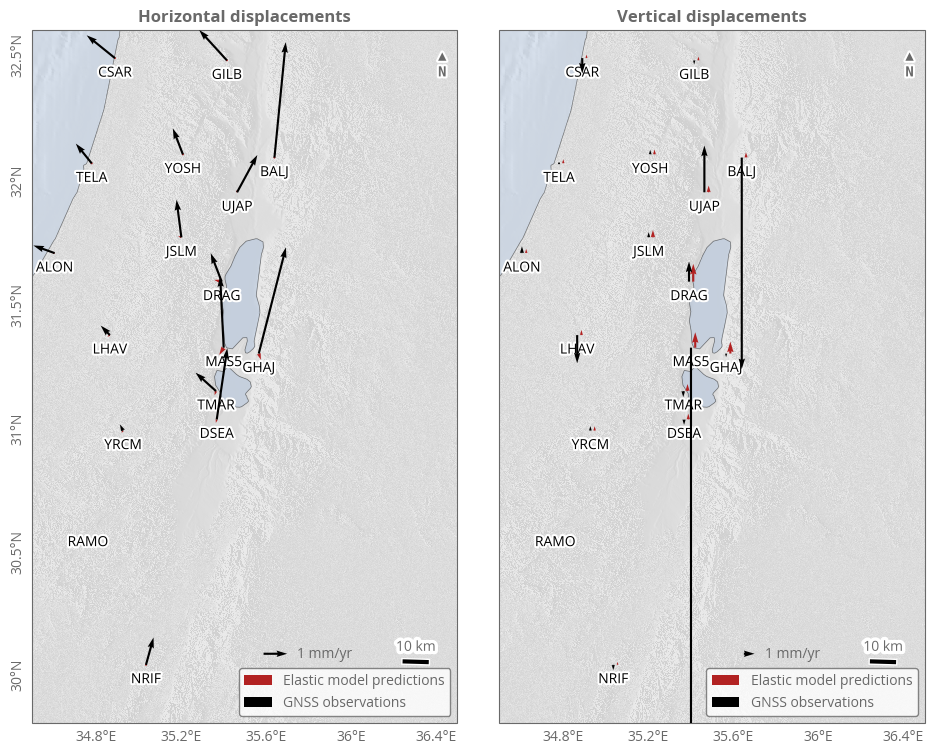

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 9), subplot_kw={'projection': ccrs.Mercator()})

for k in range(2):

    ax[k].set_extent(region)
    ax[k].pcolormesh(relief.lon, relief.lat, land_grad, cmap=cmc.grayC, transform=ccrs.PlateCarree(), alpha=.1)

    ax[k].add_feature(cf.OCEAN, facecolor='lightsteelblue', alpha=.5)
    ax[k].add_feature(cf.LAND, facecolor='lightgrey', alpha=.5)
    ax[k].add_feature(cf.COASTLINE, lw=.5, edgecolor='k', alpha=.5)
    ax[k].add_feature(cf.LAKES, linestyle='-', alpha=0.5, lw=.5, facecolor='lightsteelblue', edgecolor='k')
        
    if k == 0:
        gl = ax[k].gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.bottom_labels = True
        gl.right_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xlocator = ti.MaxNLocator(5)
        gl.ylocator = ti.MaxNLocator(6)
        gl.ylabel_style = {'rotation': 90}
    
    else:
        gl = ax[k].gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xlocator = ti.MaxNLocator(5)
        gl.ylocator = ti.MaxNLocator(5)
        gl.ylabel_style = {'rotation': 90}

    draw_scalebar(ax[k], length=10, location=(.9, .1))
    draw_north_arrow(ax[k], location=(.92, .93))

    # ax[k].scatter(list_sta.lon, list_sta.lat, transform=ccrs.PlateCarree(), marker='v', c='k', label='GNSS stations', zorder=10)
    texts = [ax[0-k].text(row.lon, row.lat-.03, row.code, transform=ccrs.PlateCarree(),
                    va='top', ha='center', color='k', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")], zorder=100) for _, row in list_sta.iterrows()]

# Horizontal
q = ax[0].quiver(sta_lon, sta_lat, v_pred[:, 0]*1e3, v_pred[:, 1]*1e3,
                 transform=ccrs.PlateCarree(), angles='uv', scale=18, color='firebrick', zorder=200, label='Elastic model predictions', width=5e-3)
q = ax[0].quiver(sta_lon, sta_lat, v_data[:, 0]*1e3, v_data[:, 1]*1e3,
                 transform=ccrs.PlateCarree(), angles='uv', scale=18, color='k', zorder=200, label='GNSS observations', width=5e-3)

ax[0].quiverkey(q, X=.6, Y=.1, U=1,
                label='1 mm/yr', labelpos='E')

# Vertical
q = ax[1].quiver(sta_lon+.02, sta_lat, np.zeros_like(v_pred[:, 2]), v_pred[:, 2]*1e3,
                 transform=ccrs.PlateCarree(), angles='uv', scale=40, color='firebrick', zorder=200, label='Elastic model predictions', width=5e-3)
q = ax[1].quiver(sta_lon, sta_lat, np.zeros_like(v_data[:, 2]), v_data[:, 2]*1e3,
                 transform=ccrs.PlateCarree(), angles='uv', scale=40, color='k', zorder=200, label='GNSS observations', width=5e-3)

ax[1].quiverkey(q, X=.6, Y=.1, U=1,
                label='1 mm/yr', labelpos='E')

ax[0].set_title('Horizontal displacements')
ax[1].set_title('Vertical displacements')

for k in range(2):
    ax[k].legend(loc='lower right')

plt.subplots_adjust(wspace=.01)
fig.savefig("{:}/elastic_deformation_dead_sea_gnss_dataVSsynthe_all.png".format(plotdir), dpi=300, bbox_inches='tight')
plt.show()

In [26]:
gnss_data['MAS5']['v_data']

array([-0.00017311,  0.00302235, -0.05607384])